In [266]:
import pandas as pd
import sqlite3

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.drawing.nx_agraph import graphviz_layout

trout_id = 578

In [102]:
# Connect to the SQLite database
conn = sqlite3.connect('nftrout.sqlite')

# Query the 'tokens' table and load it into a DataFrame
tokens_df = pd.read_sql_query("SELECT * FROM tokens", conn)

# Query the 'generations' table and load it into a DataFrame
generations_df = pd.read_sql_query("SELECT * FROM generations", conn)

# Close the connection
conn.close()

In [103]:
tokens_df.head()

,id,owner,fee,self_chain,self_id,version,name,is_genesis,is_santa,left_parent_chain,left_parent_id,right_parent_chain,right_parent_id,last_updated
0,1,0xa885b1f77e4185f98b4d4dbe752b212b18b5d551,0x1158e460913d00000,23294,1,3,Sapphire TROUT #1,1,0,NaN,NaN,NaN,NaN,2024-01-04 00:25:42
1,2,0xa885b1f77e4185f98b4d4dbe752b212b18b5d551,0x2b5e3af16b1880000,23294,2,3,Sapphire TROUT #2,1,0,NaN,NaN,NaN,NaN,2024-01-04 00:25:42
2,3,0xa885b1f77e4185f98b4d4dbe752b212b18b5d551,0xd02ab486cedc0000,23294,3,3,Sapphire TROUT #3,1,0,NaN,NaN,NaN,NaN,2024-01-04 00:25:42
3,4,0xa885b1f77e4185f98b4d4dbe752b212b18b5d551,0x1a055690d9db80000,23294,4,3,Sapphire TROUT #4,1,0,NaN,NaN,NaN,NaN,2024-01-04 00:25:42
4,5,0xa885b1f77e4185f98b4d4dbe752b212b18b5d551,0x8ac7230489e80000,23294,5,3,Sapphire TROUT #5,1,0,NaN,NaN,NaN,NaN,2024-01-04 00:25:42


In [104]:
def fetch_parent(conn, child_id):
    """Fetch the parents of a given trout."""
    query = """
    SELECT id, name, left_parent_id, right_parent_id
    FROM tokens
    WHERE id = ?
    """
    parent = conn.execute(query, (child_id,)).fetchone()
    return parent

def build_family_tree(conn, trout_id, tree=None, level=0):
    """Recursively build the family tree."""
    if tree is None:
        tree = {}

    trout = fetch_parent(conn, trout_id)
    if trout is None:
        return None

    # Add trout to the tree
    tree[trout[0]] = {'name': trout[1], 'level': level, 'children': {}}

    # Recursively add parents if they exist
    if trout[2] is not None:  # left parent
        tree[trout[0]]['children']['left'] = build_family_tree(conn, trout[2], {}, level + 1)
    if trout[3] is not None:  # right parent
        tree[trout[0]]['children']['right'] = build_family_tree(conn, trout[3], {}, level + 1)

    return tree

# Connect to the SQLite database
conn = sqlite3.connect('nftrout.sqlite')

family_tree = build_family_tree(conn, trout_id)
print(family_tree)

# Close the connection
conn.close()

{578: {'name': 'Sapphire TROUT #578', 'level': 0, 'children': {'left': {577: {'name': 'Sapphire TROUT #577', 'level': 1, 'children': {'left': {571: {'name': 'Sapphire TROUT #571', 'level': 2, 'children': {'left': {565: {'name': 'Sapphire TROUT #565', 'level': 3, 'children': {'left': {380: {'name': 'Sapphire TROUT #380', 'level': 4, 'children': {'left': {242: {'name': 'Sapphire TROUT #242', 'level': 5, 'children': {}}}, 'right': {253: {'name': 'Sapphire TROUT #253', 'level': 5, 'children': {'left': {132: {'name': 'Sapphire TROUT #132', 'level': 6, 'children': {}}}, 'right': {67: {'name': 'Sapphire TROUT #67', 'level': 6, 'children': {}}}}}}}}}, 'right': {558: {'name': 'Sapphire TROUT #558', 'level': 4, 'children': {'left': {556: {'name': 'Sapphire TROUT #556', 'level': 5, 'children': {'left': {380: {'name': 'Sapphire TROUT #380', 'level': 6, 'children': {'left': {242: {'name': 'Sapphire TROUT #242', 'level': 7, 'children': {}}}, 'right': {253: {'name': 'Sapphire TROUT #253', 'level': 7,

In [105]:
def add_nodes_edges(graph, node, level=0):
    """Recursively add nodes and edges to the graph."""
    # Extract just the number from the node's name
    node_name = node['name'].split('#')[-1].strip()
    graph.add_node(node_name, level=level)
    
    for child_id, child_node in node['children'].items():
        if child_node:
            # Now do the same for the child nodes
            for actual_child_id, actual_child in child_node.items():
                if actual_child:
                    child_name = actual_child['name'].split('#')[-1].strip()
                    graph.add_node(child_name, level=level+1)
                    # Reverse the order of the nodes here to point the arrow to the child
                    graph.add_edge(child_name, node_name)
                    add_nodes_edges(graph, actual_child, level + 1)



# Your existing database connection and family tree creation logic
conn = sqlite3.connect('nftrout.sqlite')
family_tree = build_family_tree(conn, trout_id)  # Assuming build_family_tree is defined
conn.close()

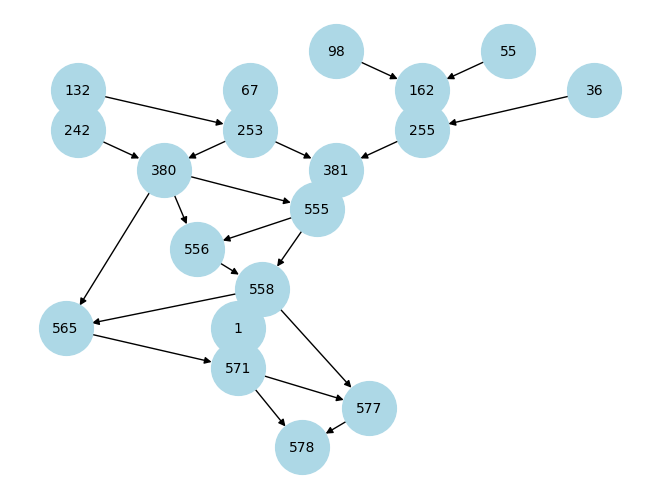

In [106]:
# Create a networkx graph and add nodes and edges
G = nx.DiGraph()
add_nodes_edges(G, family_tree[trout_id])  # Replace with your actual build tree function

# Use the Graphviz layout to position the nodes
pos = graphviz_layout(G, prog='dot', args='-Grankdir=TB')

# Draw the graph with matplotlib, now with arrows enabled
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=10, arrows=True)

# Show the plot
plt.show()

In [309]:
# Connect to the SQLite database
conn = sqlite3.connect('nftrout.sqlite')

# Execute the ancestry query
ancestry_query = """
WITH RECURSIVE ancestry(self_id, parent_id, depth) AS (
  SELECT self_id, left_parent_id, 1 FROM tokens WHERE left_parent_id IS NOT NULL
  UNION ALL
  SELECT self_id, right_parent_id, 1 FROM tokens WHERE right_parent_id IS NOT NULL
  UNION ALL
  SELECT ancestry.self_id, tokens.left_parent_id, ancestry.depth+1 
  FROM ancestry JOIN tokens ON ancestry.parent_id = tokens.self_id
  WHERE tokens.left_parent_id IS NOT NULL
  UNION ALL
  SELECT ancestry.self_id, tokens.right_parent_id, ancestry.depth+1 
  FROM ancestry JOIN tokens ON ancestry.parent_id = tokens.self_id
  WHERE tokens.right_parent_id IS NOT NULL
)
SELECT self_id, COUNT(*) - COUNT(DISTINCT parent_id) AS inbreeding_coefficient
FROM ancestry
GROUP BY self_id
ORDER BY inbreeding_coefficient DESC;
"""

# Retrieve the inbreeding coefficients into a dictionary
inbreeding_dict = {row[0]: row[1] for row in conn.execute(ancestry_query)}

# Close the connection
conn.close()

inbreeding_dict

{1070: 1430,
 724: 976,
 723: 976,
 1007: 804,
 1147: 761,
 1141: 751,
 986: 721,
 868: 721,
 722: 719,
 713: 719,
 706: 713,
 1179: 698,
 1025: 697,
 963: 697,
 959: 697,
 688: 695,
 892: 667,
 1069: 664,
 1046: 657,
 746: 657,
 1017: 654,
 1003: 654,
 1060: 613,
 1051: 612,
 1048: 611,
 816: 611,
 953: 581,
 814: 581,
 1113: 579,
 666: 578,
 664: 527,
 651: 481,
 871: 439,
 668: 426,
 660: 425,
 667: 395,
 670: 391,
 663: 358,
 1178: 332,
 632: 289,
 832: 272,
 657: 239,
 644: 238,
 661: 236,
 652: 236,
 1186: 224,
 1111: 213,
 861: 178,
 654: 171,
 648: 171,
 641: 171,
 1172: 158,
 1171: 158,
 1170: 158,
 1169: 158,
 1168: 158,
 1167: 158,
 1166: 158,
 631: 145,
 687: 142,
 676: 142,
 630: 134,
 613: 131,
 669: 125,
 643: 122,
 1165: 119,
 1164: 119,
 1162: 119,
 1160: 119,
 1159: 119,
 1158: 119,
 1156: 119,
 1074: 112,
 578: 110,
 616: 108,
 615: 108,
 675: 104,
 1064: 99,
 626: 95,
 625: 92,
 1185: 87,
 1016: 79,
 618: 78,
 610: 78,
 854: 73,
 703: 73,
 672: 73,
 614: 71,
 997: 7

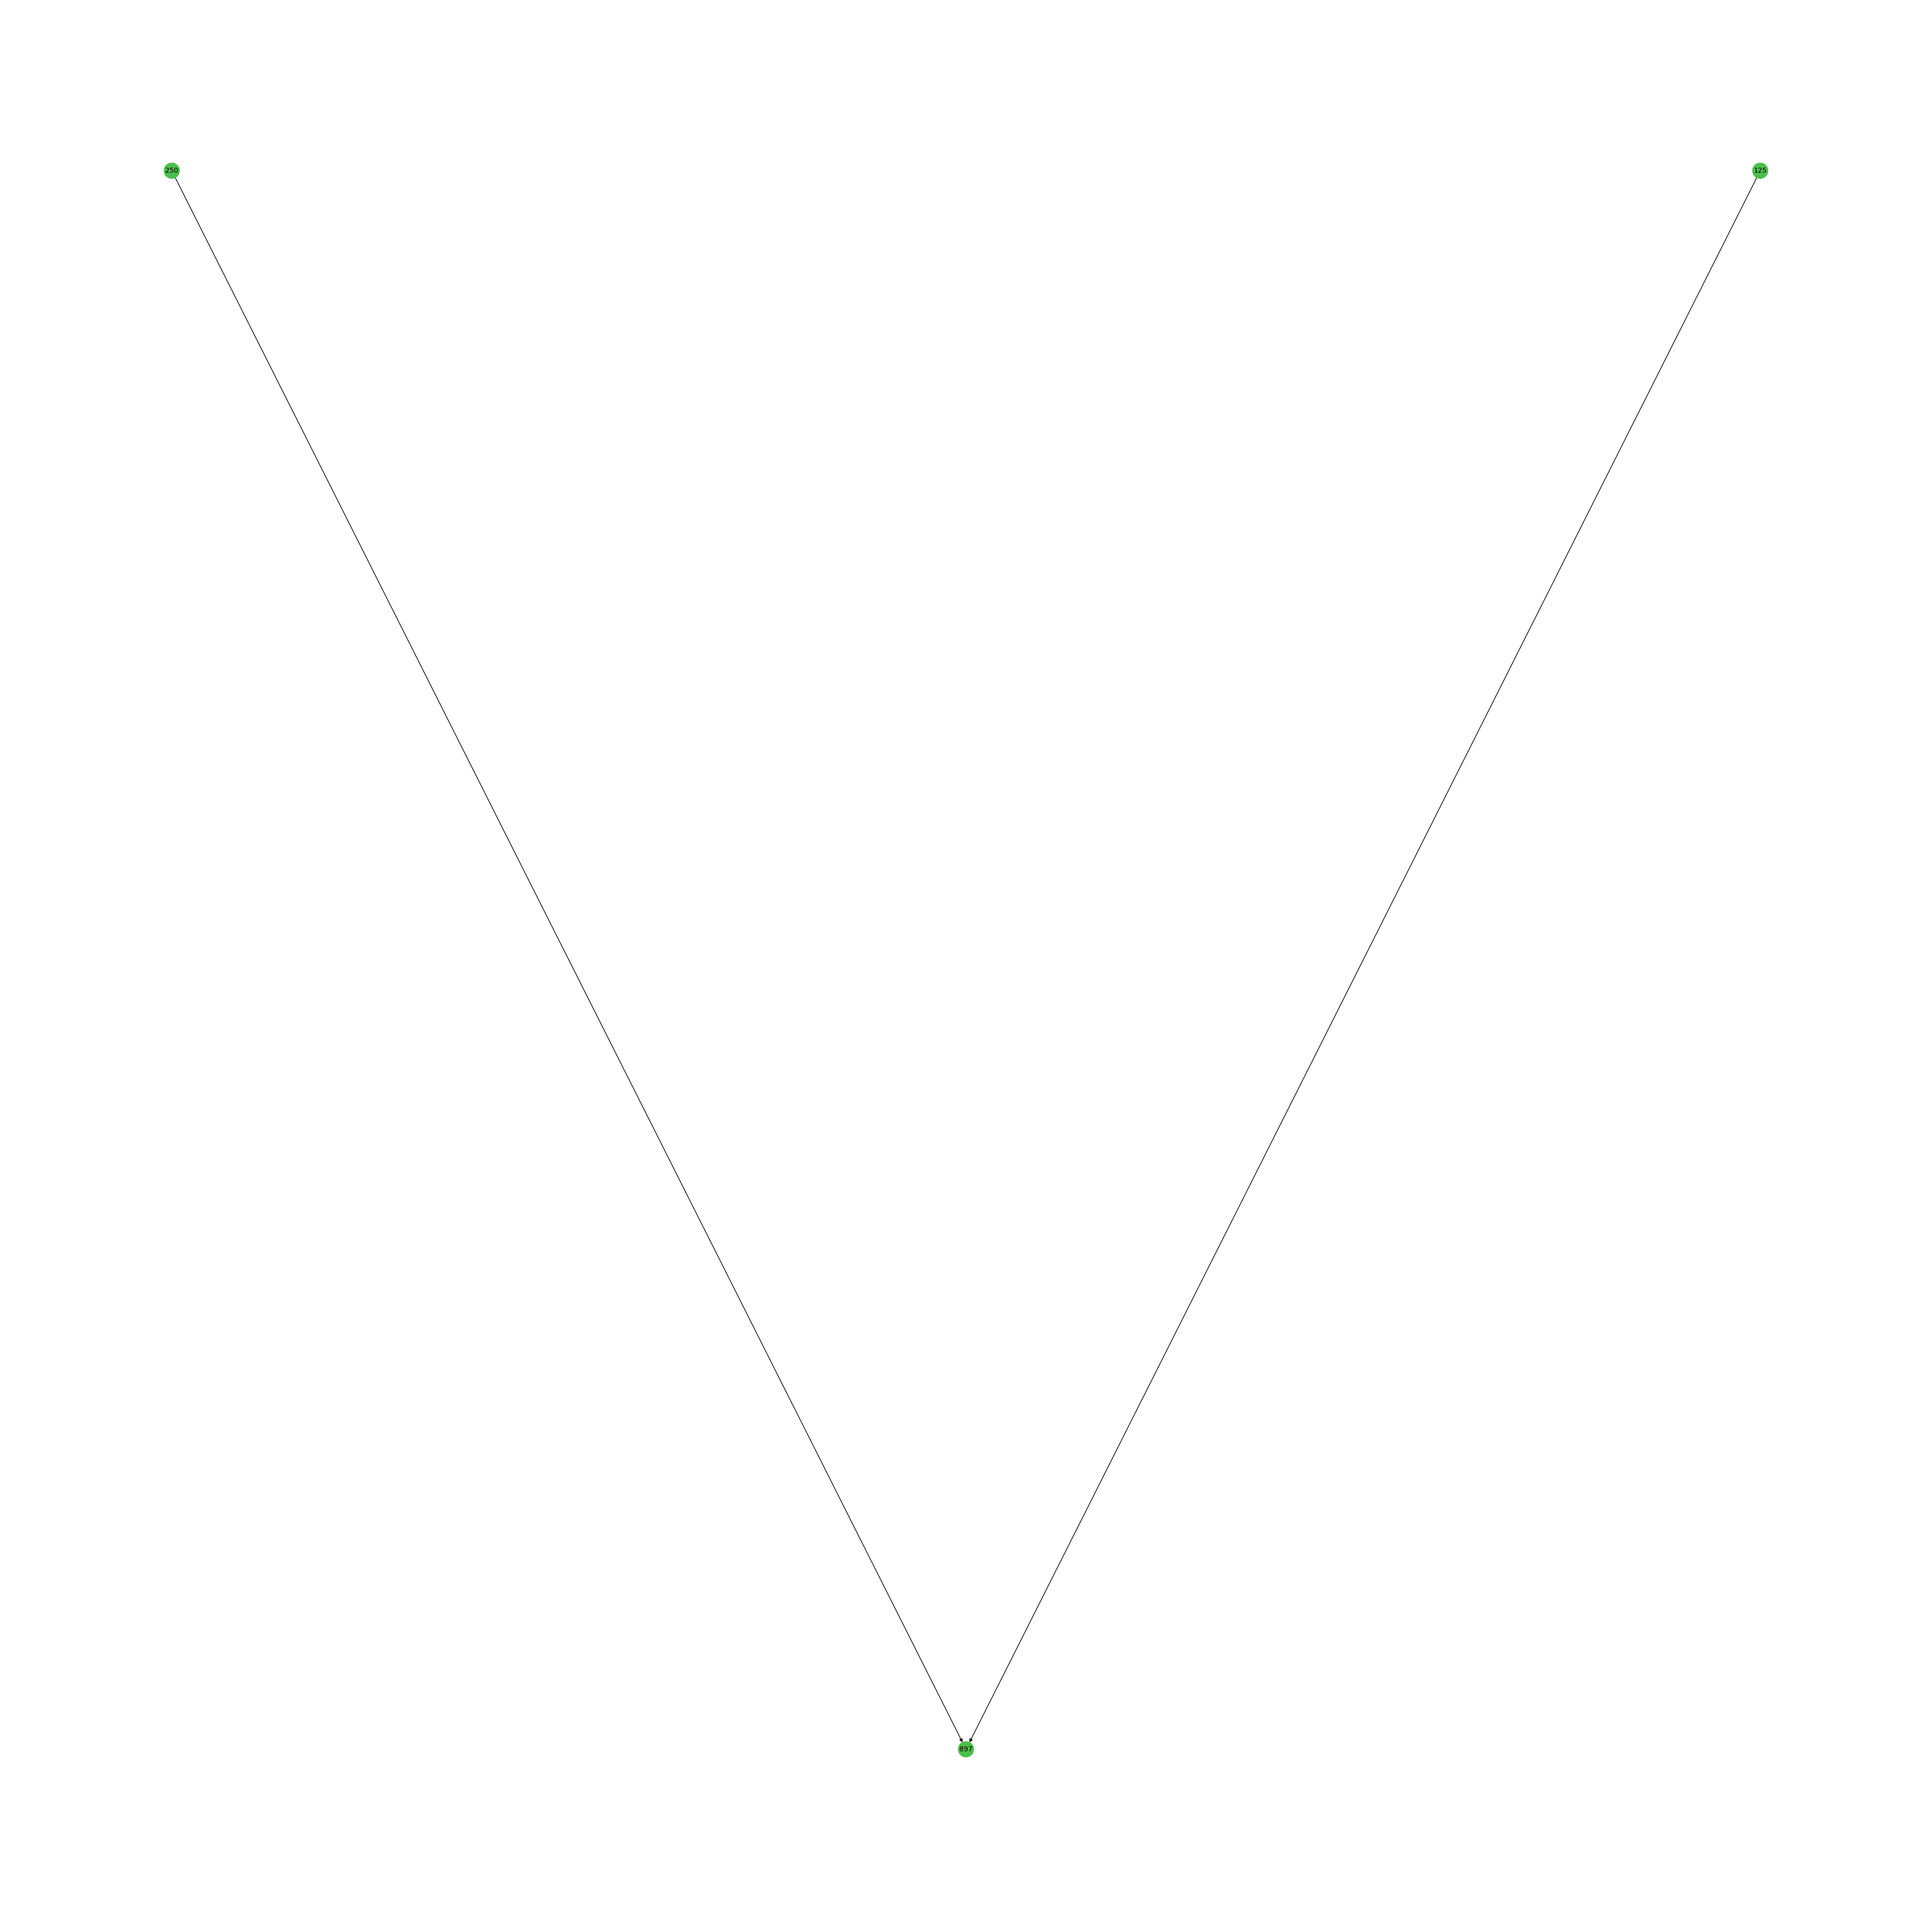

In [296]:
def add_nodes_edges(graph, node, inbreeding_dict, level=0):
    node_name = node['name'].split('#')[-1].strip()
    inbreeding_coefficient = inbreeding_dict.get(int(node_name), 0)
    graph.add_node(node_name, level=level, inbreeding=inbreeding_coefficient)
    
    for child_id, child_node in node['children'].items():
        if child_node:
            # Now do the same for the child nodes
            for actual_child_id, actual_child in child_node.items():
                if actual_child:
                    child_name = actual_child['name'].split('#')[-1].strip()
                    graph.add_node(child_name, level=level+1, inbreeding=inbreeding_dict.get(int(child_name), 0))
                    graph.add_edge(child_name, node_name)
                    # Pass inbreeding_dict properly here
                    add_nodes_edges(graph, actual_child, inbreeding_dict, level + 1)


# Define a color map with a lighter green and red gradient
def get_color(inbreeding_coefficient):
    # Normalize the inbreeding coefficient to be between 0 and 1
    normalized_coefficient = inbreeding_coefficient / 1000.0
    # Create a red-light green colormap
    color = mcolors.LinearSegmentedColormap.from_list("", ["#4bbf4b","red"])  # lighter green
    # Return the corresponding color for the normalized coefficient
    return color(normalized_coefficient)


trout_id = 897


# Your existing database connection and family tree creation logic
conn = sqlite3.connect('nftrout.sqlite')
family_tree = build_family_tree(conn, trout_id)  # Assuming build_family_tree is defined
conn.close()

# Create a networkx graph
G = nx.DiGraph()

# Now call add_nodes_edges with the inbreeding_dict
add_nodes_edges(G, family_tree[trout_id], inbreeding_dict)  # Corrected function call

# Now draw the graph using the new method
fig, ax = plt.subplots(figsize=(50, 50))
# pos = graphviz_layout(G, prog='dot', args='-Grankdir=TB')
# nx.draw_networkx_edges(G, pos, arrows=True)

# for node in G.nodes():
#     image_path = f'./static/trouts/trout_{node}.png'
#     img = Image.open(image_path)
    
#     # Do not resize to thumbnail, use the original size, or resize to a size that maintains quality
#     desired_size = (250, 200)  # Adjust as needed based on the original image size
#     img = img.resize(desired_size, Image.Resampling.LANCZOS)
    
#     xi, yi = pos[node]
#     rgba_color = get_color(G.nodes[node].get('inbreeding', 0))

#     # Adjust zoom factor to match the image size
#     zoom_factor = desired_size[0] / img.size[0]

#     xi, yi = pos[node]
#     rgba_color = get_color(G.nodes[node].get('inbreeding', 0))
#     border_size = 100
#     border_rect = Rectangle((xi - border_size / 2, yi - border_size / 3),
#                             border_size, border_size / 3, linewidth=2,
#                             edgecolor=rgba_color, facecolor='none', zorder=0)
#     # ax.add_patch(border_rect)

#     im = OffsetImage(img, zoom=zoom_factor)
#     ab = AnnotationBbox(im, (xi, yi), xycoords='data', frameon=False, zorder=1)
#     ax.add_artist(ab)
#     ax.text(xi, yi + border_size / 4 + 2, f'#{node}', ha='center', va='bottom', zorder=2, color='black', fontsize=20)

# plt.axis('off')


# Use the Graphviz layout to position the nodes
pos = graphviz_layout(G, prog='dot', args='-Grankdir=TB')

# Use the inbreeding attribute to set the color of each node
node_colors = [get_color(G.nodes[node]['inbreeding']) for node in G.nodes()]

# Draw the graph with node colors based on inbreeding coefficient
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, arrows=True)

plot_filename = 'family_tree_image.png'
plt.savefig(f'./static/{plot_filename}', dpi=300)

# Show the plot
plt.show()

In [311]:
conn = sqlite3.connect('nftrout.sqlite')

# Get all trout IDs
trout_ids = pd.read_sql_query("SELECT self_id FROM tokens", conn)['self_id'].tolist()

# Variables to keep track of the trout with the biggest tree of parents
trout_with_biggest_tree = None
biggest_tree_size = 0

# Variables to track the largest ancestor and descendant trees
trout_with_largest_ancestor_tree = None
largest_ancestor_tree_size = 0

trout_with_largest_descendant_tree = None
largest_descendant_tree_size = 0

for trout_id in trout_ids:
    # Build the family tree for the current trout
    family_tree = build_family_tree(conn, trout_id)
    descendant_tree = build_full_descendant_tree(conn, trout_id)

    # Create a new graph for the current trout's family tree
    G_ancestors = nx.DiGraph()
    add_nodes_edges(G_ancestors, family_tree[trout_id], {})  # Assuming add_nodes_edges function is defined
    ancestor_tree_size = len(G_ancestors)

    G_descendants = nx.DiGraph()
    add_descendants_to_graph(G_descendants, trout_id, descendant_tree, {})
    descendant_tree_size = len(G_descendants)

    # Compute the size of the family tree (number of ancestors plus descendants)
    full_tree_size = ancestor_tree_size + descendant_tree_size - 1  # Subtract 1 to account for the trout itself being counted twice

    # Update if this tree is bigger than the previously found biggest tree
    if full_tree_size > biggest_tree_size:
        biggest_tree_size = full_tree_size
        trout_with_biggest_tree = trout_id

    # Update if this ancestor tree is the largest
    if ancestor_tree_size > largest_ancestor_tree_size:
        largest_ancestor_tree_size = ancestor_tree_size
        trout_with_largest_ancestor_tree = trout_id

    # Update if this descendant tree is the largest
    if descendant_tree_size > largest_descendant_tree_size:
        largest_descendant_tree_size = descendant_tree_size
        trout_with_largest_descendant_tree = trout_id

conn.close()

# Print the results
print(f"The trout with the biggest full tree is: {trout_with_biggest_tree} with a tree size of {biggest_tree_size}.")
print(f"The trout with the largest ancestor tree is: {trout_with_largest_ancestor_tree} with a tree size of {largest_ancestor_tree_size}.")
print(f"The trout with the largest descendant tree is: {trout_with_largest_descendant_tree} with a tree size of {largest_descendant_tree_size}.")


The trout with the biggest full tree is: 55 with a tree size of 534.
The trout with the largest ancestor tree is: 1364 with a tree size of 94.
The trout with the largest descendant tree is: 55 with a tree size of 534.


{55: {'name': 'Trout #55', 'level': 0, 'children': [{156: {156: {'name': 'Trout #156', 'level': 1, 'children': []}}}, {162: {162: {'name': 'Trout #162', 'level': 1, 'children': [{255: {255: {'name': 'Trout #255', 'level': 2, 'children': [{381: {381: {'name': 'Trout #381', 'level': 3, 'children': [{555: {555: {'name': 'Trout #555', 'level': 4, 'children': [{556: {556: {'name': 'Trout #556', 'level': 5, 'children': [{558: {558: {'name': 'Trout #558', 'level': 6, 'children': [{565: {565: {'name': 'Trout #565', 'level': 7, 'children': [{571: {571: {'name': 'Trout #571', 'level': 8, 'children': [{577: {577: {'name': 'Trout #577', 'level': 9, 'children': [{578: {578: {'name': 'Trout #578', 'level': 10, 'children': []}}}]}}}, {578: {578: {'name': 'Trout #578', 'level': 9, 'children': []}}}, {584: {584: {'name': 'Trout #584', 'level': 9, 'children': [{610: {610: {'name': 'Trout #610', 'level': 10, 'children': [{618: {618: {'name': 'Trout #618', 'level': 11, 'children': []}}}]}}}, {625: {625: {

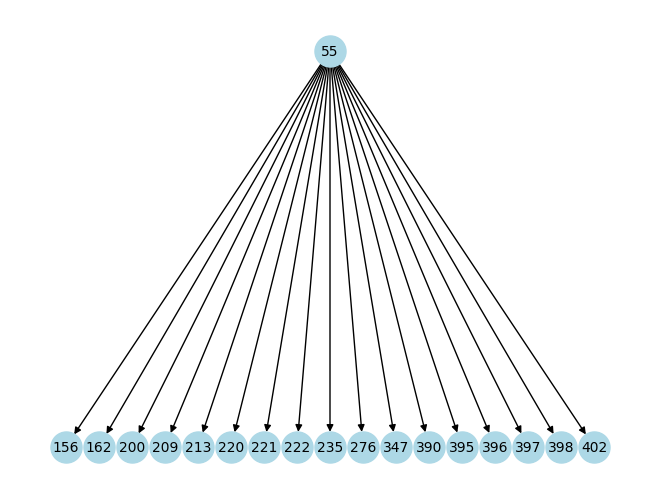

In [153]:
def fetch_children(conn, parent_id):
    """Fetch the children of a given trout."""
    query = """
    SELECT id, name
    FROM tokens
    WHERE left_parent_id = ? OR right_parent_id = ?
    """
    children = conn.execute(query, (parent_id, parent_id)).fetchall()
    return children

def build_descendant_tree(conn, trout_id, tree=None, level=0):
    """Recursively build the descendant tree."""
    if tree is None:
        tree = {}

    children = fetch_children(conn, trout_id)
    if not children:
        return None

    # Add trout to the tree
    tree[trout_id] = {'name': f'Trout #{trout_id}', 'level': level, 'children': []}

    # Recursively add children
    for child in children:
        child_id = child[0]
        child_tree = build_descendant_tree(conn, child_id, {}, level + 1)
        if child_tree:
            tree[trout_id]['children'].append({child_id: child_tree})

    return tree

def add_descendant_nodes_edges(graph, node, tree, level=0):
    node_name = f'{node}'
    graph.add_node(node_name, level=level)

    # Check if the current node has children
    if node in tree and 'children' in tree[node]:
        for child_dict in tree[node]['children']:
            child_id = list(child_dict.keys())[0]
            child_name = f'{child_id}'
            graph.add_node(child_name, level=level+1)
            graph.add_edge(node_name, child_name)
            # Pass the entire tree and child_id to the recursive call
            add_descendant_nodes_edges(graph, child_id, tree, level + 1)


trout_id = 55  # Replace with the trout ID you're interested in

# Connect to the SQLite database
conn = sqlite3.connect('nftrout.sqlite')

# Build the descendant tree for the specified trout
descendant_tree = build_descendant_tree(conn, trout_id)

print(descendant_tree)

# Close the connection
conn.close()

# Create a networkx graph and add nodes and edges for descendants
G = nx.DiGraph()
add_descendant_nodes_edges(G, trout_id, descendant_tree)

# Use the Graphviz layout to position the nodes
pos = graphviz_layout(G, prog='dot', args='-Grankdir=TB')

# Draw the graph with matplotlib
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, arrows=True)

# Show the plot
plt.show()

In [304]:
conn = sqlite3.connect('nftrout.sqlite')

query = """
SELECT parent_id, COUNT(*) as num_children
FROM (
    SELECT left_parent_id as parent_id FROM tokens WHERE left_parent_id IS NOT NULL
    UNION ALL
    SELECT right_parent_id as parent_id FROM tokens WHERE right_parent_id IS NOT NULL
)
GROUP BY parent_id
ORDER BY num_children DESC
LIMIT 1;
"""

# Execute the query
cursor = conn.cursor()
cursor.execute(query)
result = cursor.fetchone()

conn.close()

if result:
    trout_id, num_children = result
    print(f"The trout with the most children is Trout #{trout_id} with {num_children} children.")
else:
    print("No trout found.")

The trout with the most children is Trout #5 with 50 children.


In [306]:
conn = sqlite3.connect('nftrout.sqlite')

query = """
SELECT parent_id, COUNT(*) as num_children
FROM (
    SELECT left_parent_id as parent_id FROM tokens WHERE left_parent_id IS NOT NULL
    UNION ALL
    SELECT right_parent_id as parent_id FROM tokens WHERE right_parent_id IS NOT NULL
)
GROUP BY parent_id
ORDER BY num_children DESC
LIMIT 10;
"""

# Execute the query
cursor = conn.cursor()
cursor.execute(query)
results = cursor.fetchall()

conn.close()

# Check if any results were found
if results:
    print("Top 10 ")
    for i, (trout_id, num_children) in enumerate(results, start=1):
        print(f"{i}. #{trout_id} | {num_children}")
else:
    print("No trout found.")


Top 10 
1. #5 | 50
2. #55 | 49
3. #7 | 42
4. #1 | 38
5. #3 | 33
6. #121 | 30
7. #237 | 26
8. #41 | 22
9. #36 | 21
10. #6 | 20


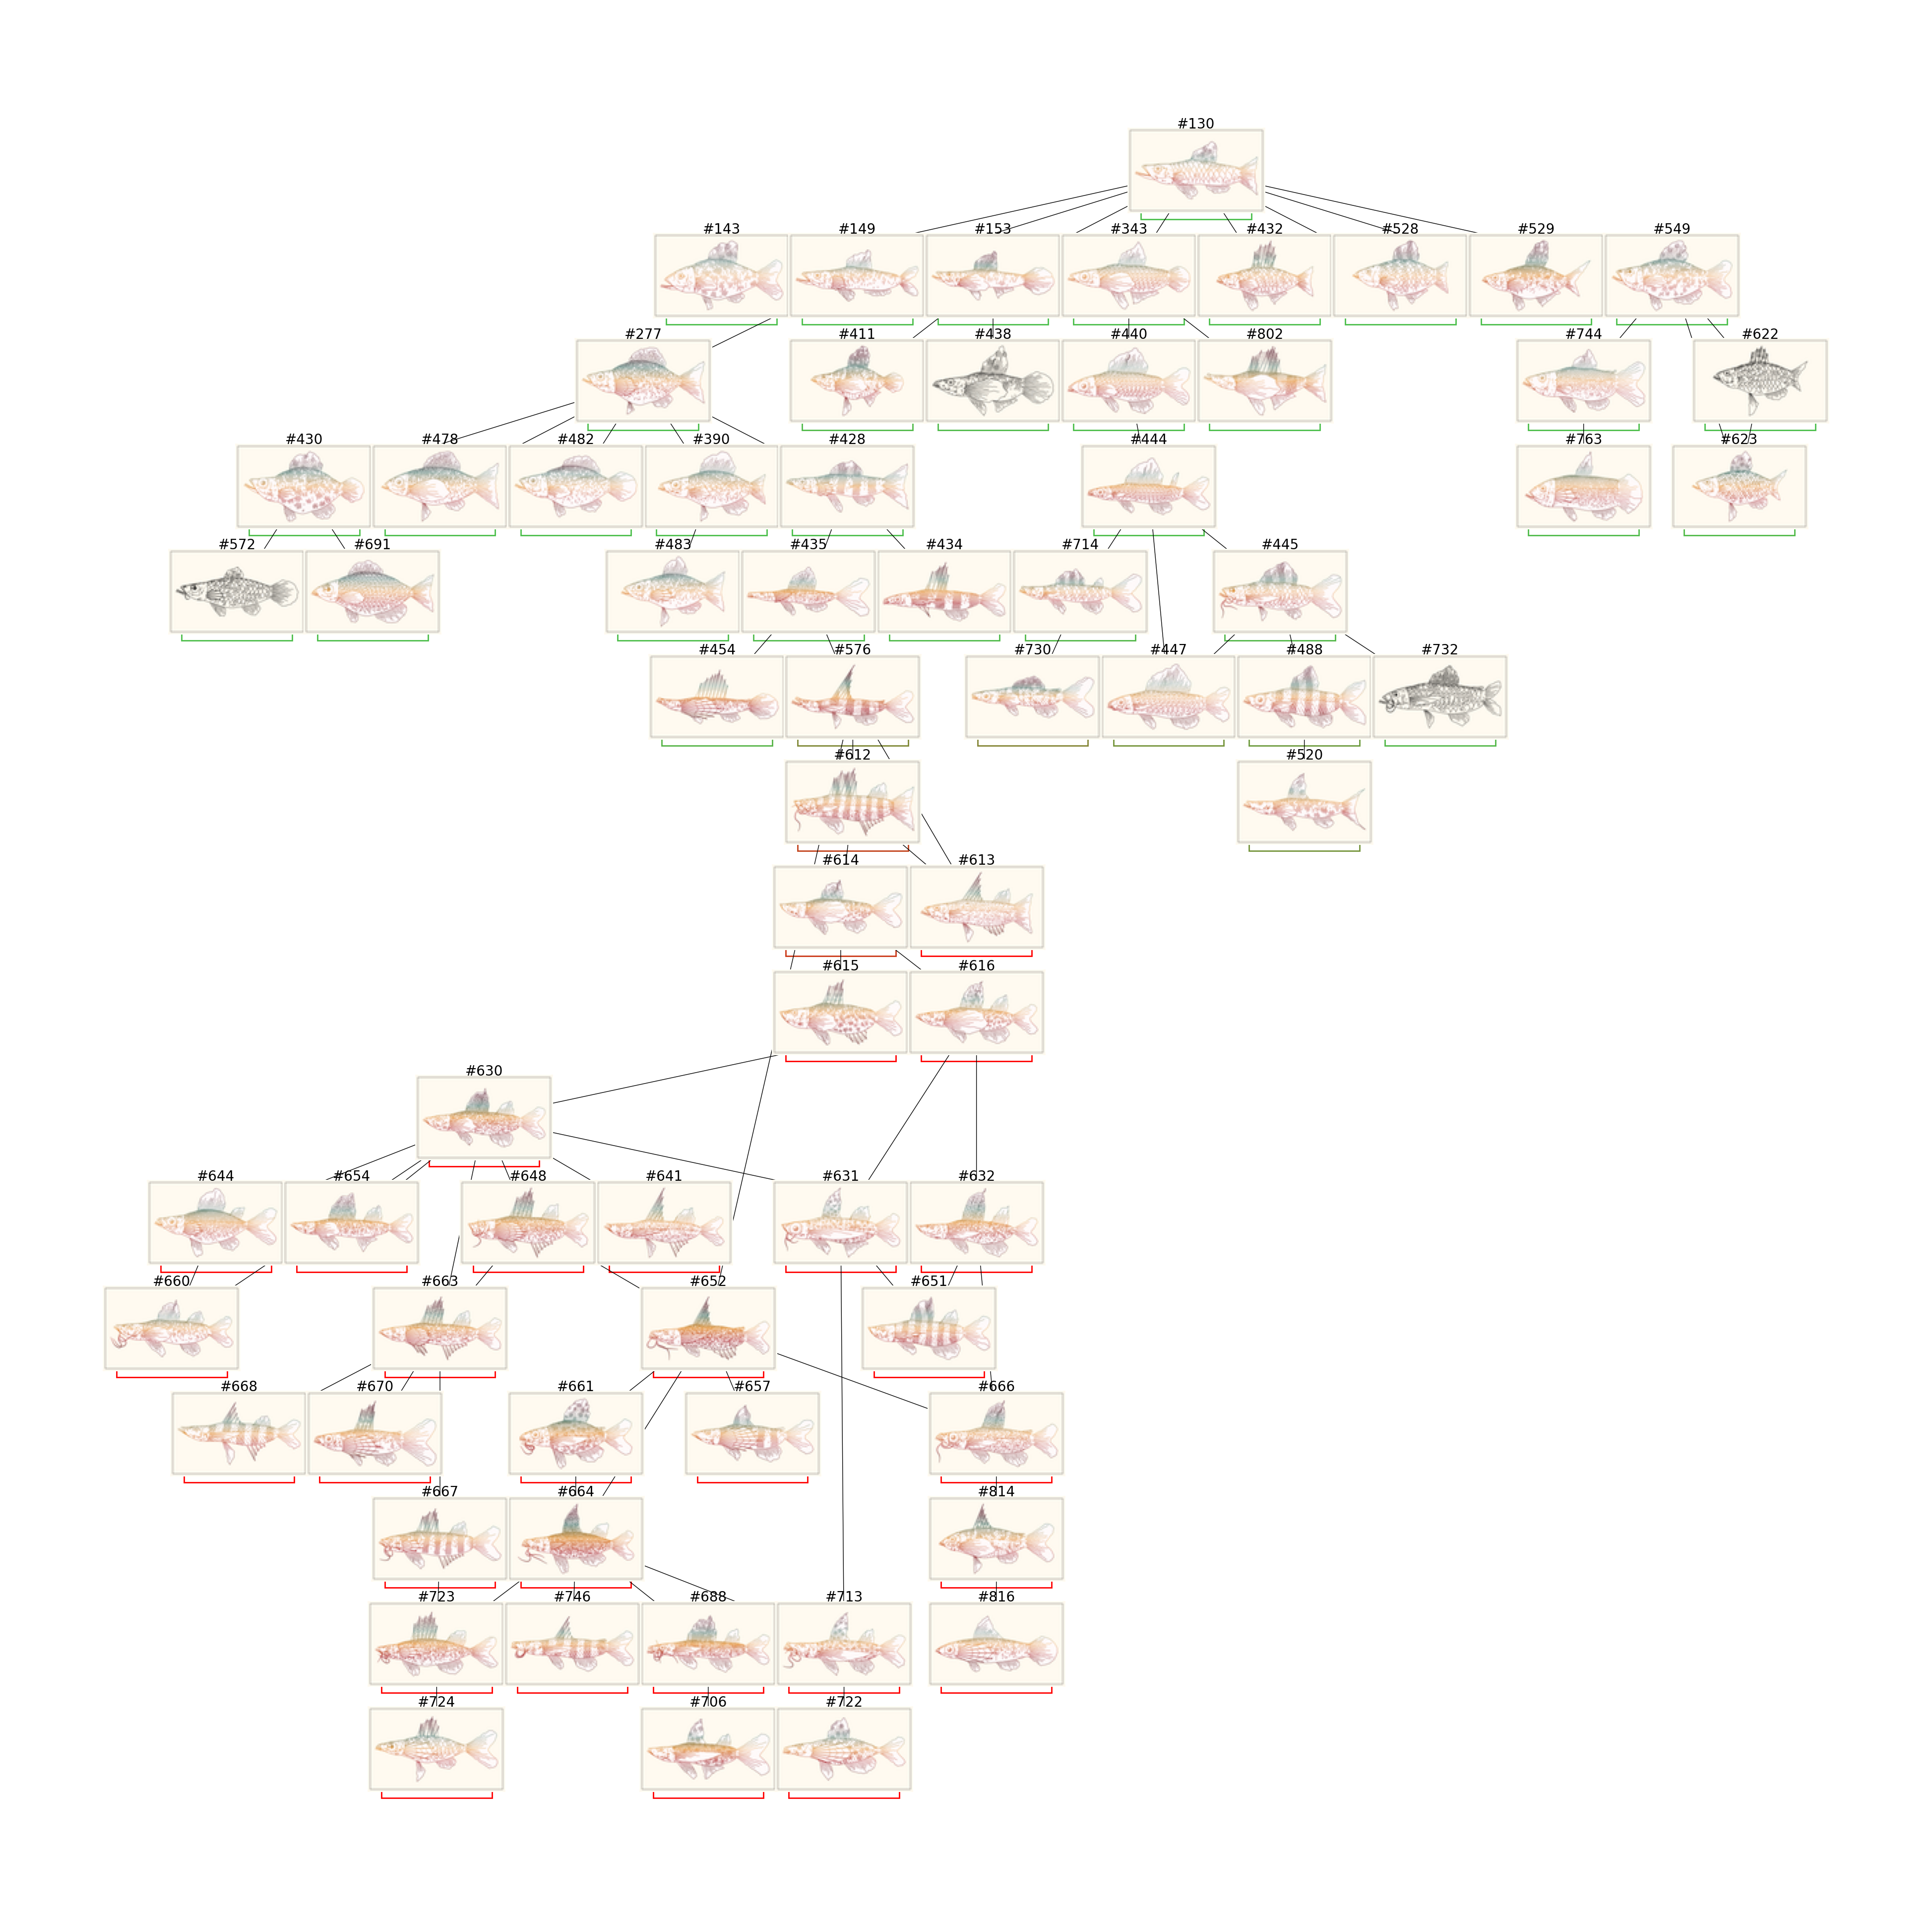

In [263]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
from PIL import Image

from matplotlib.patches import Rectangle

def fetch_direct_descendants(conn, parent_id):
    """Fetch the direct descendants of a given trout."""
    query = """
    SELECT id, name
    FROM tokens
    WHERE left_parent_id = ? OR right_parent_id = ?
    """
    descendants = conn.execute(query, (parent_id, parent_id)).fetchall()
    return descendants


def build_full_descendant_tree(conn, trout_id):
    """Recursively build the full descendant tree of a given trout."""
    descendants = {}
    direct_descendants = fetch_direct_descendants(conn, trout_id)

    for descendant_id, name in direct_descendants:
        # Recursive call to build the descendant subtree
        descendants[descendant_id] = build_full_descendant_tree(conn, descendant_id)

    return descendants

def add_descendants_to_graph(graph, parent_id, descendants, inbreeding_dict):
    """Recursively add descendants to the graph."""
    for child_id, grandchildren in descendants.items():
        # Include the inbreeding coefficient when adding the node
        inbreeding_coefficient = inbreeding_dict.get(child_id, 0)
        graph.add_node(child_id, label=f'Trout #{child_id}', inbreeding=inbreeding_coefficient)
        graph.add_edge(parent_id, child_id)
        add_descendants_to_graph(graph, child_id, grandchildren, inbreeding_dict)

# Define a color map with a lighter green and red gradient
def get_color(inbreeding_coefficient):
    # Normalize the inbreeding coefficient to be between 0 and 1
    normalized_coefficient = inbreeding_coefficient / 100.0
    # Create a red-light green colormap
    color = mcolors.LinearSegmentedColormap.from_list("", ["#4bbf4b","red"])  # lighter green
    # Return the corresponding color for the normalized coefficient
    return color(normalized_coefficient)
    
# Connect to the SQLite database
conn = sqlite3.connect('nftrout.sqlite')

# Fetch the inbreeding coefficients
inbreeding_dict = {row[0]: row[1] for row in conn.execute(ancestry_query)}

# Build the full descendant tree for the given trout
trout_id = 130  # Replace with the trout ID you're interested in
descendant_tree = build_full_descendant_tree(conn, trout_id)

# Close the database connection
conn.close()

# Create a graph and add the descendant tree to it
G = nx.DiGraph()

# If the root trout is not in the inbreeding_dict, set its coefficient to 0 or a default value
root_inbreeding_coefficient = inbreeding_dict.get(trout_id, 0)
G.add_node(trout_id, label=f'Trout #{trout_id}', inbreeding=root_inbreeding_coefficient)

# Add descendants to the graph
add_descendants_to_graph(G, trout_id, descendant_tree, inbreeding_dict)

# Use the Graphviz layout to position the nodes
pos = graphviz_layout(G, prog='dot', args='-Grankdir=TB')

# Set up a very large plot size. You can adjust this as needed.
fig, ax = plt.subplots(figsize=(50, 50))  # This can be very large, e.g., (50, 50) inches

# Draw the graph edges using the positions from graphviz_layout
nx.draw_networkx_edges(G, pos, arrows=True)

# For each node, place an image with a square border
for node in G.nodes():
    image_path = f'./static/trouts/trout_{node}.png'
    img = Image.open(image_path)
    img.thumbnail((100, 100), Image.Resampling.LANCZOS)  # Adjust the size as needed
    xi, yi = pos[node]

    # Get the color for the node as an RGBA tuple
    rgba_color = get_color(G.nodes[node]['inbreeding'])

    # Draw a square with the node color as a border
    border_size = 100  # This should be relative to your image size
    border_rect = Rectangle((xi - border_size / 2, yi - border_size / 3),
                            border_size, border_size/3, linewidth=2,
                            edgecolor=rgba_color, facecolor='none', zorder=0)
    ax.add_patch(border_rect)

    # Place the image on the graph, with increased zoom for larger images
    im = OffsetImage(img, zoom=2)  # Increase the zoom factor as needed
    ab = AnnotationBbox(im, (xi, yi), xycoords='data', frameon=False, zorder=1)
    ax.add_artist(ab)

    # Add the trout number as text above the image, adjust font size as needed
    ax.text(xi, yi + border_size / 4 + 2, f'#{node}', ha='center', va='bottom', zorder=2, color='black', fontsize=20)

# Remove the axis
plt.axis('off')

# Show the plot
plt.show()

In [315]:
# Connect to the SQLite database
conn = sqlite3.connect('nftrout.sqlite')

# Query to find the trout with the longest lineage
query = """
WITH RECURSIVE lineage(self_id, depth) AS (
    SELECT self_id, 0 as depth FROM tokens WHERE is_genesis = 1
    UNION ALL
    SELECT t.self_id, l.depth + 1 as depth
    FROM tokens t
    INNER JOIN lineage l ON t.left_parent_id = l.self_id OR t.right_parent_id = l.self_id
)
SELECT self_id, MAX(depth) as longest_lineage FROM lineage GROUP BY self_id ORDER BY longest_lineage DESC LIMIT 1;
"""

# Execute the query
cursor = conn.cursor()
cursor.execute(query)
result = cursor.fetchone()

# Close the connection
conn.close()

# Output the result
if result:
    print(f"The trout with the longest lineage is: Trout #{result[0]} with a lineage length of {result[1]}.")
else:
    print("No trout found with lineage information.")

The trout with the longest lineage is: Trout #1364 with a lineage length of 20.


In [316]:
import os
import requests
import cairosvg

def generate_trout_image_url(trout_number):
    return f'https://api.nftrout.com/trout/23294/{trout_number}/image.svg'

def download_and_convert_trout_images(trout_range, directory='./static/trouts'):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for trout_number in trout_range:
        url = generate_trout_image_url(trout_number)
        response = requests.get(url)
        
        if response.status_code == 200:
            svg_file_path = os.path.join(directory, f'trout_{trout_number}.svg')
            png_file_path = os.path.join(directory, f'trout_{trout_number}.png')
            
            with open(svg_file_path, 'wb') as file:
                file.write(response.content)
            
            # Convert SVG to PNG
            cairosvg.svg2png(url=svg_file_path, write_to=png_file_path)
            
            # Remove the SVG file if you don't need it to save space
            os.remove(svg_file_path)
        else:
            print(f"Failed to download image for trout #{trout_number}")

# Example usage: Download and convert images for trout 1 through 100
download_and_convert_trout_images(range(1370, 1378))
